## Train model for all subjects

In [8]:
model_name = 'DWTs'

### Import libraries

In [9]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.feature_selection import mutual_info_classif


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss
from sklearn.model_selection import cross_validate

from matplotlib.colors import LinearSegmentedColormap
from mne import create_info
from mne.viz import plot_topomap

### Import data

In [10]:
filename = '/mnt/d/sharegit/MasterThesis_data/DWTs/pp01_t16.csv'
df = pd.read_csv(filename, header=None)

### Prepare Data

In [11]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'AFz', 'CPz', 'POz']
patterns = ['_d1', '_d2', '_d3', '_d4', '_d5', '_a1']
column_names = ['channels', 'ID', 'Class', 'Epoch'] + [f'{ch}{pt}' for ch in channels for pt in patterns]

if len(column_names) != len(df.columns):
    raise ValueError(f"Number of column names ({len(column_names)}) does not match number of columns in DataFrame ({len(df.columns)})")

df.columns = column_names
df.head()

,channels,ID,Class,Epoch,Fp1_d1,Fp1_d2,Fp1_d3,Fp1_d4,Fp1_d5,Fp1_a1,...,CPz_d3,CPz_d4,CPz_d5,CPz_a1,POz_d1,POz_d2,POz_d3,POz_d4,POz_d5,POz_a1
0,5,1,1,1,0.575075,0.136032,0.123487,0.093560,0.057901,0.013945,...,0.140594,0.042888,0.025799,0.006609,0.336483,0.220715,0.231677,0.101612,0.089528,0.019985
1,5,1,1,2,0.509184,0.262941,0.106593,0.072962,0.037227,0.011093,...,0.163608,0.041396,0.009745,0.001428,0.244889,0.384025,0.221724,0.070184,0.060243,0.018934
2,5,1,1,3,0.490340,0.191802,0.204283,0.070682,0.033491,0.009402,...,0.218914,0.044268,0.010597,0.001778,0.273779,0.215197,0.395480,0.070791,0.033080,0.011673
3,5,1,1,4,0.436777,0.235945,0.218578,0.060795,0.038248,0.009657,...,0.273868,0.036003,0.010619,0.001746,0.369812,0.265958,0.274095,0.053359,0.028603,0.008174
4,5,1,1,5,0.398432,0.307515,0.197477,0.053886,0.033593,0.009097,...,0.303220,0.038299,0.007286,0.001249,0.214284,0.327662,0.322558,0.071483,0.049477,0.014537


### Load data into data_array

In [12]:
def load_IDs(df, IDs,types,mod):
    df = df[df['Class'].isin(types)]
    
    class_mapping = dict(zip(types, mod))
    df['Class'] = df['Class'].map(class_mapping)
    
    # Filter the dataframe for the provided IDs
    df = df[df['ID'].isin(IDs)]
    
    # Drop unnecessary columns
    df = df.drop(columns=['channels', 'ID', 'Epoch'])
    
    # Prepare data and labels
    data_array = df.drop(['Class'], axis=1).values
    class_labels = df['Class'].values
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(data_array, class_labels, test_size=0.2, random_state=42)
    print(df.shape[0])
    return X_train, X_test, y_train, y_test
    
# Example usage
types = [1,2,3,4,5,6,7,8,9,10,11,12]
mod = ['Air','Air','Air','Air','Vib','Vib','Vib','Vib','Car','Car','Car','Car']
IDs = range(1, 35)
X_train, X_test, y_train, y_test = load_IDs(df, IDs,types,mod)

7548


In [13]:
print(set(IDs))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34}


### Train models

In [14]:
def print_scores(name, scores):
    mean_test_accuracy = np.mean(scores['test_accuracy']) * 100
    std_test_accuracy = np.std(scores['test_accuracy']) * 100
    mean_test_precision = np.mean(scores['test_precision_macro'])
    mean_test_recall = np.mean(scores['test_recall_macro'])
    mean_test_f1 = np.mean(scores['test_f1_macro'])
    mean_test_roc_auc = np.mean(scores['test_roc_auc_ovr'])
    
    print(f"------------------------------------------------------------")
    print(f"Average K-Fold Test Accuracy of {name}: {mean_test_accuracy:.2f}%")
    print(f"Std Dev of K-Fold Test Accuracy of {name}: {std_test_accuracy:.2f}%")
    print(f"Average K-Fold Test Precision of {name}: {mean_test_precision:.2f}")
    print(f"Average K-Fold Test Recall of {name}: {mean_test_recall:.2f}")
    print(f"Average K-Fold Test F1 Score of {name}: {mean_test_f1:.2f}")
    print(f"Average K-Fold Test ROC AUC of {name}: {mean_test_roc_auc:.2f}")
    print(f"------------------------------------------------------------")
    
def RForest_train(X_train, y_train, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', validation='standard', cv=5, echo=True):
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                      min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                      max_features=max_features, random_state=42)
    
    scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc_ovr']
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, return_train_score=True)

    model.fit(X_train, y_train)
    
    if echo:
        print_scores('Random Forest', scores)
    return scores, model


def KNN_train(X_train, y_train, hot_encode=False, n_neighbors=20, p=1, weights='distance', leaf_size=20, algorithm='auto', validation='standard', cv=5, echo=True):
    model = KNeighborsClassifier(n_neighbors=n_neighbors, p=p, weights=weights, leaf_size=leaf_size, algorithm=algorithm)

    scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc_ovr']
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, return_train_score=True)
    
    model.fit(X_train, y_train)
    
    if echo:
        print_scores('KNN', scores)
    return scores, model


def MLP_train(X_train, y_train,  hot_encode=False, hidden_layer_sizes=(100,), activation='relu', solver='adam', validation='standard', alpha=0.001, cv=5, max_iter=200, echo=True):
    model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, alpha=alpha, batch_size='auto', learning_rate='constant', 
                              learning_rate_init=0.001, power_t=0.5, max_iter=max_iter, shuffle=True, random_state=None, tol=0.0001, verbose=False, 
                              warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, 
                              beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)

    scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc_ovr']
    scores = cross_validate(model,X_train, y_train, cv=cv, scoring=scoring, return_train_score=True)
    
    model.fit(X_train, y_train)

    if echo:
        print_scores('MLP', scores)
    return scores, model

def train_all(X_train, y_train):

    models = []
    scores = []
    
    score, model = KNN_train(X_train, y_train, cv = 10)
    models.append(model)
    scores.append(score)
    
    score, model =RForest_train(X_train, y_train,  cv = 10)
    models.append(model)
    scores.append(score)
    
    score, model = MLP_train(X_train, y_train, hidden_layer_sizes=(200, 100, 50), max_iter=10000, alpha=0.001, cv=10)
    models.append(model)
    scores.append(score)
    
    return models, scores

models,scores = train_all(X_train, y_train)

------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 55.65%
Std Dev of K-Fold Test Accuracy of KNN: 1.14%
Average K-Fold Test Precision of KNN: 0.56
Average K-Fold Test Recall of KNN: 0.55
Average K-Fold Test F1 Score of KNN: 0.55
Average K-Fold Test ROC AUC of KNN: 0.75
------------------------------------------------------------
------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 70.11%
Std Dev of K-Fold Test Accuracy of Random Forest: 2.29%
Average K-Fold Test Precision of Random Forest: 0.71
Average K-Fold Test Recall of Random Forest: 0.70
Average K-Fold Test F1 Score of Random Forest: 0.70
Average K-Fold Test ROC AUC of Random Forest: 0.87
------------------------------------------------------------
------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 63.76%
Std Dev of K-Fold Test Accuracy of MLP: 1.74%
Average K-Fold Test Precision of 

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 70.11%
Std Dev of K-Fold Test Accuracy of Random Forest: 2.29%
Average K-Fold Test Precision of Random Forest: 0.71
Average K-Fold Test Recall of Random Forest: 0.70
Average K-Fold Test F1 Score of Random Forest: 0.70
Average K-Fold Test ROC AUC of Random Forest: 0.87
------------------------------------------------------------


100%|===================| 18095/18114 [07:53<00:00]        

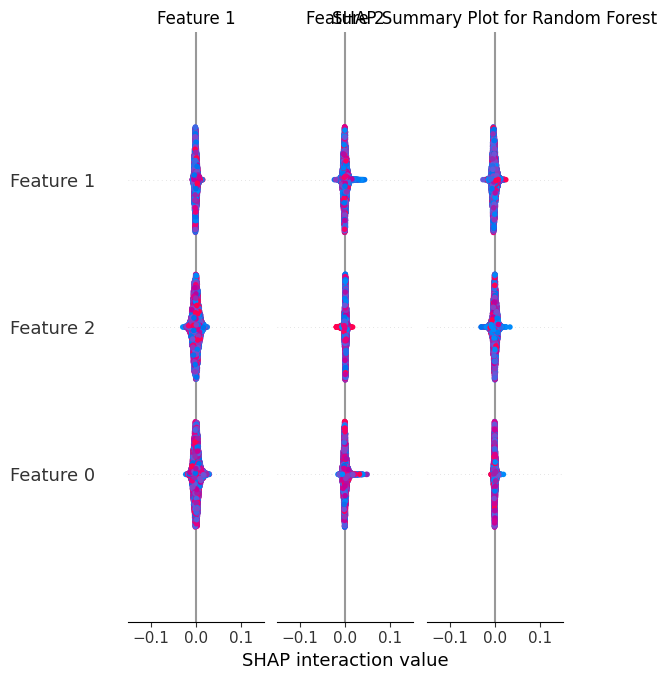

In [16]:
import shap
import matplotlib.pyplot as plt
def compute_shap_values(model, X_train):
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_train)
    return shap_values

def plot_shap_values(shap_values, X_train, model_name):
    shap.summary_plot(shap_values, X_train, show=False)
    plt.title(f"SHAP Summary Plot for {model_name}")
    plt.show()


def train_all_with_shap(X_train, y_train):

    models = []
    scores = []
    shap_values_list = []
    model_names = ['Random Forest']

    score, model = RForest_train(X_train, y_train, cv=10)
    models.append(model)
    scores.append(score)
    shap_values = compute_shap_values(model, X_train)
    shap_values_list.append(shap_values)


    # Plot SHAP values for each model
    for shap_values, model_name in zip(shap_values_list, model_names):
        plot_shap_values(shap_values, X_train, model_name)
    
    return models, scores, shap_values_list

# Assuming X_train and y_train are already defined
models, scores, shap_values_list = train_all_with_shap(X_train, y_train)


In [24]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values_list[0][0][:,1], feature_names=column_names[4:], show=False)

TypeError: waterfall() got an unexpected keyword argument 'feature_names'

In [ ]:
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode

def calculate_acc(y_test_encoded, models):
    ensemble_preds = np.zeros((len(y_test_encoded), len(models)))
    accs = []
    # Loop over each model to get predictions and calculate individual accuracies
    for i, (model, name) in enumerate(zip(models, ['KNN', 'Random Forest','MLP'])):
        pred = model.predict(X_test)
        
        # Convert string predictions to numerical form
        pred_encoded = le.transform(pred)
        
        acc = np.mean(pred_encoded == y_test_encoded)
        accs.append(acc)
        print(f"{name} Classification Accuracy: {acc}")
        
        # Store the numerical predictions for ensemble averaging
        ensemble_preds[:, i] = pred_encoded

    # Average the predictions using mode for classification
    ensemble_final_preds_encoded = mode(ensemble_preds, axis=1)[0].flatten()
    
    # Convert numerical predictions back to string labels
    ensemble_final_preds = le.inverse_transform(ensemble_final_preds_encoded.astype(int))
    
    # Calculate the ensemble accuracy
    ensemble_acc = np.mean(ensemble_final_preds == y_test)
    print(f"Ensemble Classification Accuracy: {ensemble_acc}")
    return accs, ensemble_preds
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)
accs,ensemble_preds = calculate_acc(y_test_encoded, models)

In [ ]:
print(accs[1])

In [ ]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For enhanced confusion matrix visualization

def plot_confusion_matrix(ax, cm, classes, title, vmin, vmax):
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    tick_marks = range(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

def plot_all_cm(y_test_encoded, ensemble_preds, names):
    # Compute confusion matrices
    cm_knn = confusion_matrix(y_test_encoded, ensemble_preds[:, 0])
    cm_rf = confusion_matrix(y_test_encoded, ensemble_preds[:, 1])
    cm_mlp = confusion_matrix(y_test_encoded, ensemble_preds[:, 2])
    
    # Find the global vmin and vmax for all confusion matrices
    all_cms = [cm_knn, cm_rf, cm_mlp]
    vmin = min(cm.min() for cm in all_cms)
    vmax = max(cm.max() for cm in all_cms)
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot each confusion matrix with shared vmin and vmax
    plot_confusion_matrix(axes[0], cm_knn, names, 'KNN', vmin, vmax)
    plot_confusion_matrix(axes[1], cm_rf, names, 'Random Forest', vmin, vmax)
    plot_confusion_matrix(axes[2], cm_mlp, names, 'MLP', vmin, vmax)
    
    # Create a single color bar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    plt.colorbar(axes[0].images[0], cax=cbar_ax)
    plt.show()
names = ['Air','Vib','Car']
plot_all_cm(y_test_encoded, ensemble_preds, names)


## Features Selection

### Colormap and functions definition

In [11]:
import seaborn as sns
import os
# Define the custom colormap
cdict = {
    'red':   [(0.0, 0.0, 0.0),
              (0.33, 0.0, 0.0),
              (0.66, 1.0, 1.0),
              (1.0, 1.0, 1.0)],
    'green': [(0.0, 0.3, 0.3),  
              (0.33, 1.0, 1.0),
              (0.66, 1.0, 1.0),
              (1.0, 0.0, 0.0)],
    'blue':  [(0.0, 0.9, 0.9),  
              (0.33, 1.0, 1.0),
              (0.66, 0.0, 0.0),
              (1.0, 0.0, 0.0)]
}

custom_cmap = LinearSegmentedColormap('CustomJet', segmentdata=cdict, N=256)

def get_mutualInfo(X_train, y_train):
    mutual_info_scores = mutual_info_classif(X_train, y_train)
    selected_features = np.where(mutual_info_scores > 0)[0]
    
    X_train_sf = X_train[:, selected_features]
    X_test_sf = X_test[:, selected_features]

    channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'AFz', 'CPz', 'POz']
    patterns = ['d1', 'd2', 'd3', 'd4', 'd5', 'a1']
    feature_names = [f'{ch}_{pt}' for ch in channels for pt in patterns]
    
    scores_matrix = mutual_info_scores.reshape(len(channels), len(patterns))
    
    #print(f"Number of features selected: {len(selected_features)}")
    return scores_matrix,X_train_sf,X_test_sf
    
def plot_matrix_MI(X_train, y_train, custom_cmap, save = False, model_name = '',fig_name= ''):
    channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'AFz', 'CPz', 'POz']
    patterns = ['d1', 'd2', 'd3', 'd4', 'd5', 'a1']
    feature_names = [f'{ch}_{pt}' for ch in channels for pt in patterns]
    
    scores_matrix,X_train_sf,X_test_sf = get_mutualInfo(X_train, y_train)
    scores_df = pd.DataFrame(scores_matrix, index=channels, columns=patterns)
    plt.figure(figsize=(10, 8))
    sns.heatmap(scores_df, annot=True, fmt=".3f", cmap=custom_cmap)
    plt.title('Heatmap of Mutual Information Scores')
    plt.xlabel('Patterns')
    plt.ylabel('Channels')
    plt.show()
    if save:
        plt.savefig(f'/mnt/d/sharegit/MasterThesis_data/{model_name}/{fig_name}.png')

scores_matrix, X_train_sf, X_test_sf = get_mutualInfo(X_train, X_test, y_train)
print("Scores matrix:\n", scores_matrix)
print("Selected features (train):\n", X_train_sf.shape)
print("Selected features (test):\n", X_test_sf.shape)

### Plot Matrix Mutual information

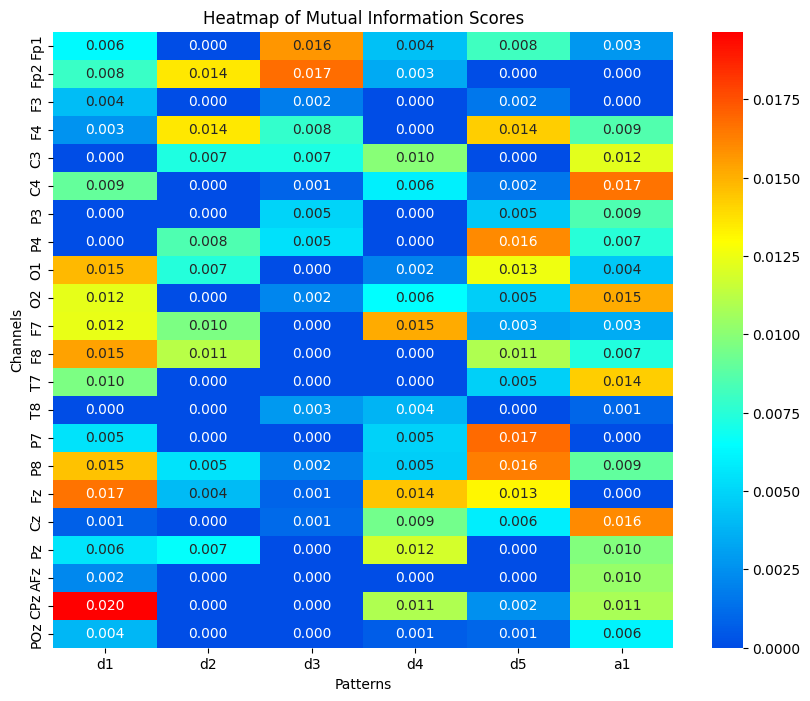

<Figure size 640x480 with 0 Axes>

In [12]:
plot_matrix_MI(X_train, y_train, custom_cmap,save = True, model_name = model_name, fig_name = 'all_subs_confmat')

### Plot as channel location 

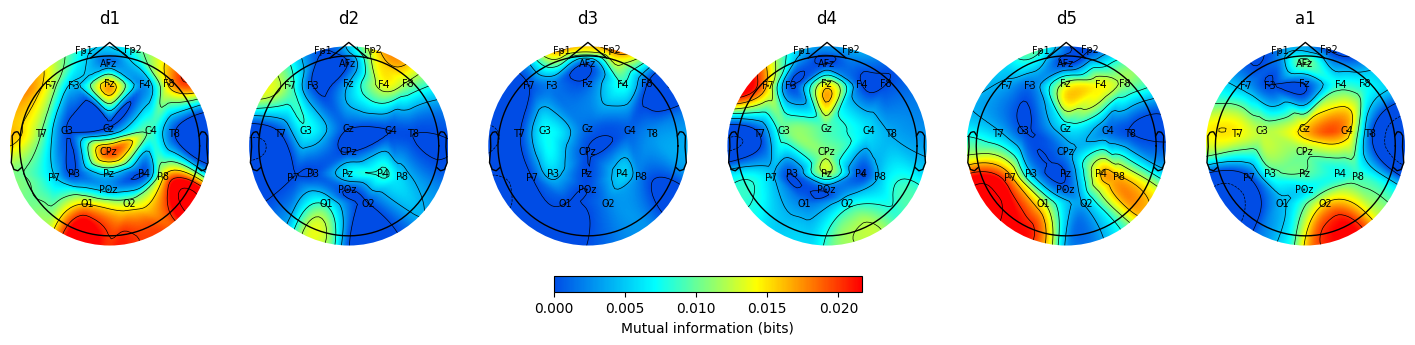

In [13]:
channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'AFz', 'CPz', 'POz']

# Create info structure
info = create_info(channels, sfreq=250, ch_types='eeg')
info.set_montage(montage = "standard_1020",match_alias = True)

plot_topoplot(X_train, y_train, info, custom_cmap,save = True,  model_name = model_name, fig_name = 'all_subs_topoplot')


## SHAP Values

In [32]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate


In [33]:
channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'AFz', 'CPz', 'POz']
patterns = ['_d1', '_d2', '_d3', '_d4', '_d5', '_a1']
feature_names = [f'{ch}{pt}' for ch in channels for pt in patterns]

In [36]:
def compute_shap_values(model, X_train):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    return shap_values

def group_shap_values(shap_values, feature_names, group_by='channel'):
    # Aggregate SHAP values across all classes for each feature
    shap_values_sum = np.sum(np.abs(shap_values), axis=0)
    
    if len(shap_values_sum.shape) == 3:  # in case of multiple classes
        shap_values_sum = np.sum(shap_values_sum, axis=0)
    
    feature_df = pd.DataFrame(shap_values_sum, columns=feature_names)
    
    if group_by == 'channel':
        groups = {ch: [col for col in feature_names if col.startswith(ch)] for ch in channels}
    elif group_by == 'pattern':
        groups = {pt: [col for col in feature_names if col.endswith(pt)] for pt in patterns}
    else:
        raise ValueError("group_by must be 'channel' or 'pattern'")
    
    grouped_shap_values = {group: feature_df[cols].sum(axis=1).values for group, cols in groups.items()}
    return grouped_shap_values

def plot_grouped_shap_values(grouped_shap_values, group_by='channel'):
    shap_means = {group: np.mean(values) for group, values in grouped_shap_values.items()}
    sorted_shap_means = sorted(shap_means.items(), key=lambda x: x[1], reverse=True)
    
    plt.figure(figsize=(10, 5))
    plt.barh([x[0] for x in sorted_shap_means], [x[1] for x in sorted_shap_means])
    plt.xlabel('Mean SHAP Value')
    plt.ylabel(group_by.capitalize())
    plt.title(f'Mean SHAP Values Grouped by {group_by.capitalize()}')
    plt.gca().invert_yaxis()
    plt.show()

    
def train_random_forest_with_shap(X_train, y_train):
    model = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', random_state=42)
    model.fit(X_train, y_train)
    
    shap_values = compute_shap_values(model, X_train)
    return model, shap_values

In [28]:
# Assuming X_train and y_train are already defined
model, shap_values = train_random_forest_with_shap(X_train, y_train)


In [42]:
# Group by channels
grouped_shap_values_by_channel = group_shap_values(shap_values, feature_names, group_by='channel')
plot_grouped_shap_values(grouped_shap_values_by_channel, group_by='channel')

# Group by patterns
grouped_shap_values_by_pattern = group_shap_values(shap_values, feature_names, group_by='pattern')
plot_grouped_shap_values(grouped_shap_values_by_pattern, group_by='pattern')


ValueError: Shape of passed values is (132, 3), indices imply (132, 132)

100%|===================| 4527/4530 [01:59<00:00]        

TypeError: only integer scalar arrays can be converted to a scalar index

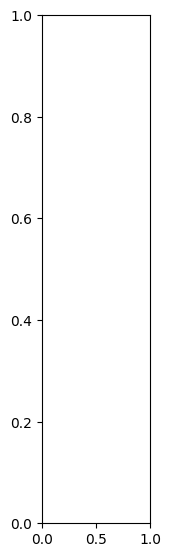

In [43]:
# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Create a SHAP explainer
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test)

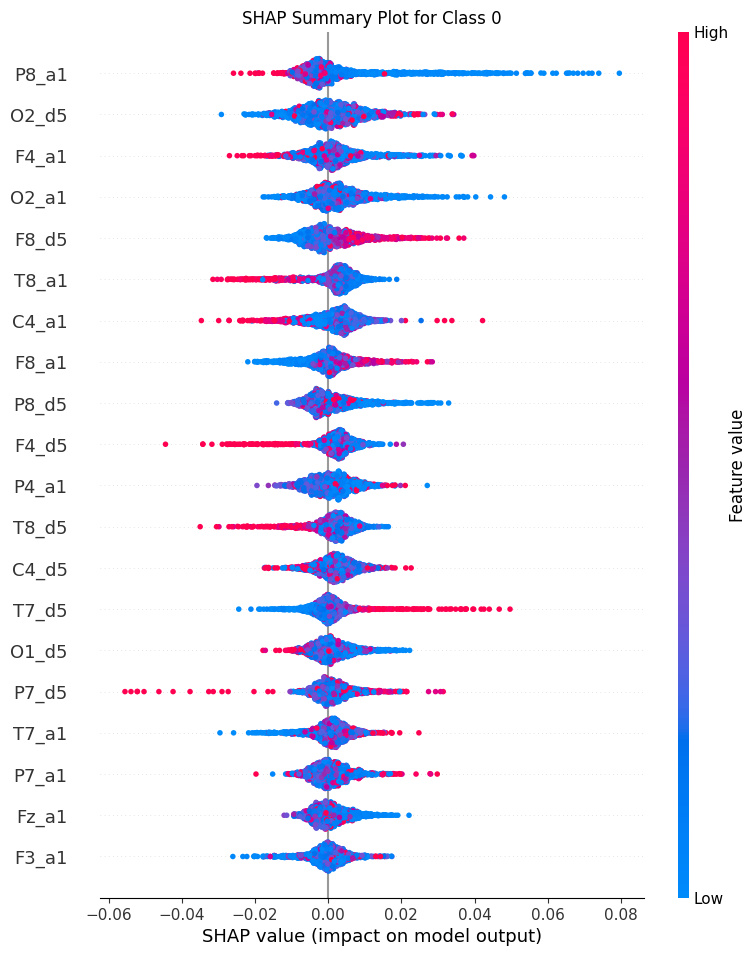

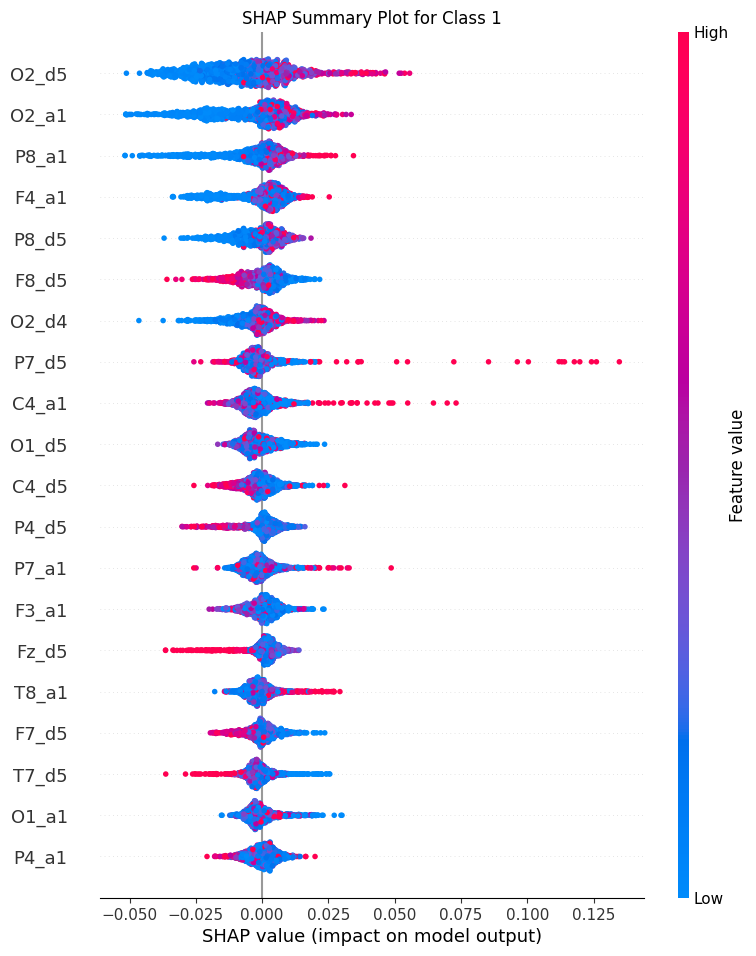

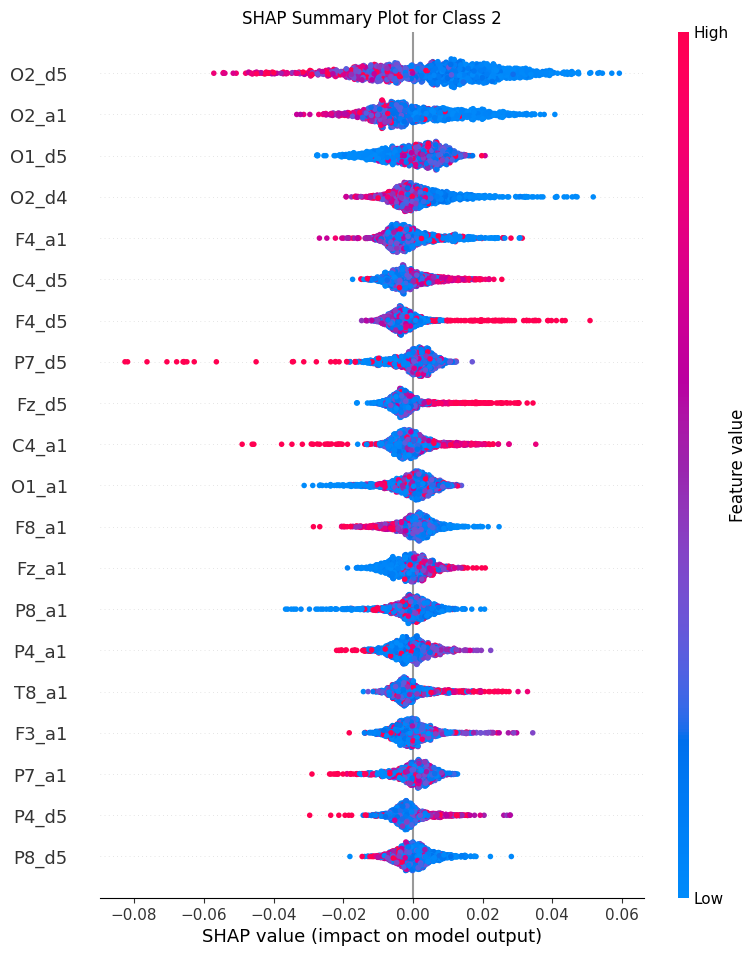

/tmp/ipykernel_3441/2203994077.py:14: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  channels_shap = shap_values_df.groupby([fn.split('_')[0] for fn in feature_names], axis=1).mean()


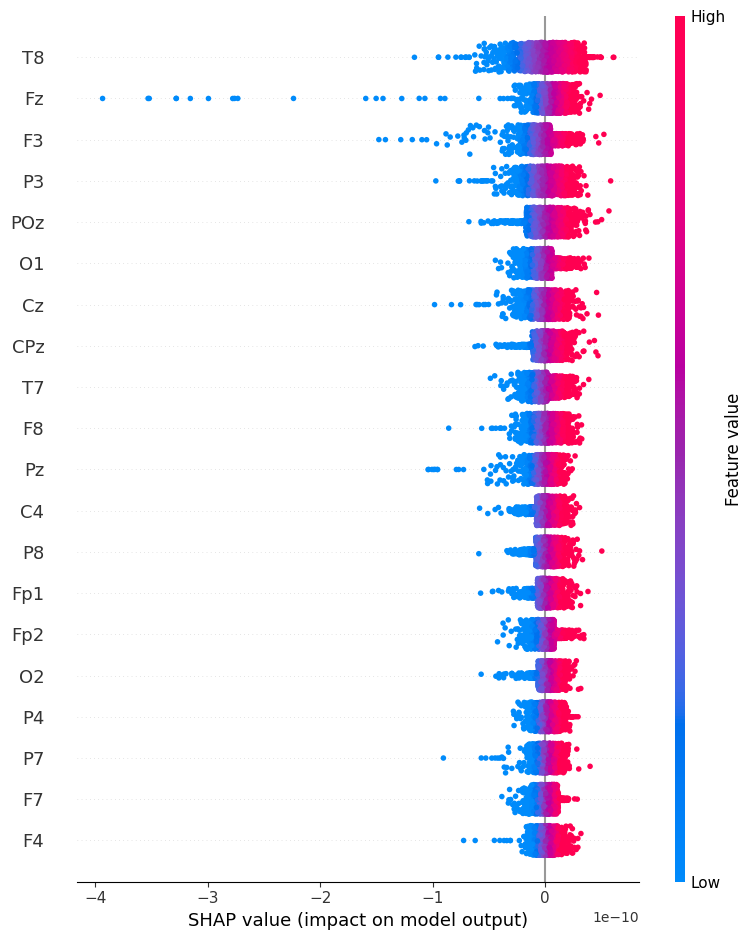

/tmp/ipykernel_3441/2203994077.py:18: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  patterns_shap = shap_values_df.groupby([fn.split('_')[1] for fn in feature_names], axis=1).mean()


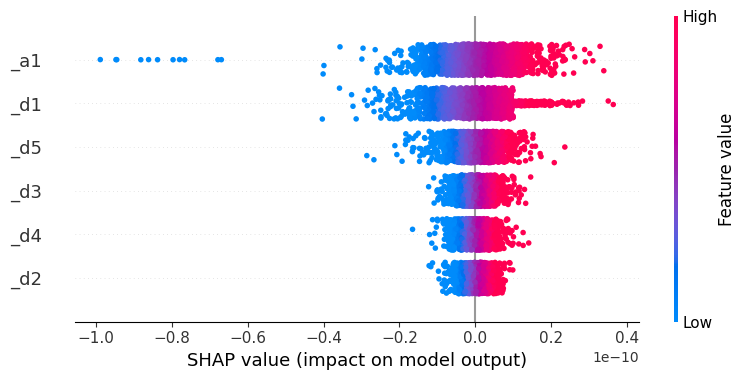

In [45]:
# Plot SHAP summary plot for each class
for class_idx in range(shap_values.shape[2]):
    shap.summary_plot(shap_values[:,:,class_idx], X_test, feature_names=feature_names, show=False)
    plt.title(f'SHAP Summary Plot for Class {class_idx}')
    plt.show()

# Aggregate SHAP values across classes (e.g., mean)
shap_values_mean = np.mean(shap_values.values, axis=2)

# Group SHAP values by channels or patterns
shap_values_df = pd.DataFrame(shap_values_mean, columns=feature_names)

# Group by channels
channels_shap = shap_values_df.groupby([fn.split('_')[0] for fn in feature_names], axis=1).mean()
shap.summary_plot(channels_shap.values, features=channels_shap, feature_names=channels)

# Group by patterns
patterns_shap = shap_values_df.groupby([fn.split('_')[1] for fn in feature_names], axis=1).mean()
shap.summary_plot(patterns_shap.values, features=patterns_shap, feature_names=patterns)